###### <img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">PyTorch Tutorial SWDB 2022 </h1> 
<h3 align="center">Tuesday, August 30, 2022</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
Many of the problems and methods we have seen rely on optimizations that use some form of gradient descent.  For a reminder, gradient descent methods update the parameters of some model according to the negative of the gradient of a cost function with respect to those parameters, in order to minimize that cost function.  
</p>
 </div>   

In [1]:
import torch

In [2]:
import numpy as np
from sklearn import datasets

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

For simple functions and parameter sets, this computation is not that hard to compute.  Let's look at an example.  Here we will explicitly build a classifier by hand that we discussed in the Classification tutorial. </p>
</div>

In [3]:
def plot_classes(X,y):
    
    classes = np.unique(y)
    num_classes = len(classes)
    
    color = 'rbgmyk'
    
    fig, ax = plt.subplots(figsize=(8,8))
    for cl in range(num_classes):
        ax.scatter(X[y==cl,0],X[y==cl,1],c=color[cl],edgecolor='none')
    ax.set_xlim(X[:,0].min(),X[:,0].max())
    ax.set_ylim(X[:,1].min(),X[:,1].max())

In [4]:
X, y = datasets.make_classification(n_features=2,n_redundant=0,random_state=1,n_samples=1000)
        
print(np.shape(X))
print(np.shape(y))

(1000, 2)
(1000,)


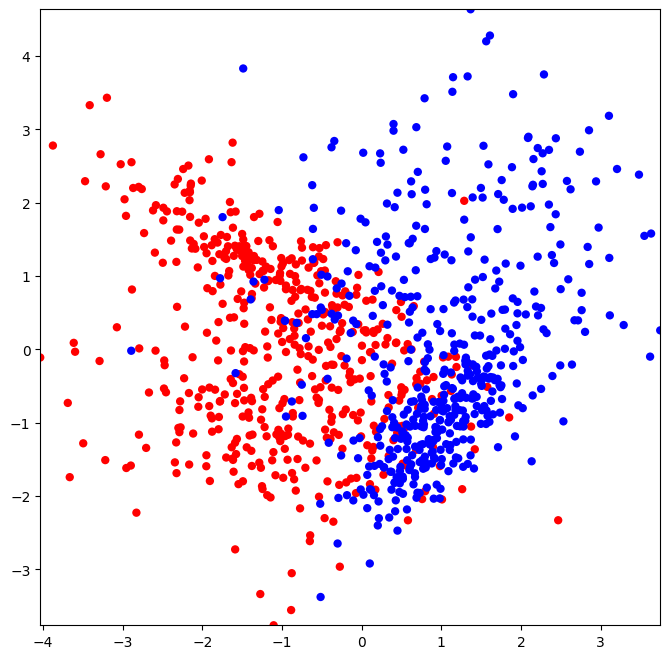

In [5]:
plot_classes(X,y)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
The two classes above are labeled `0` and `1`.  Logistic Regression is a form of binary classification that computes the probability of membership in class `1` according to the following form:

$ P_1(x) = \frac{1}{1 + e^{-\vec{w}\cdot \vec{x} - b}}$

with $P_2 = 1 - P_1$.  Fitting this model requires selecting the vector $\vec{w}$ and the constant $b$ to minimize the *negative log likelihood*:

$ {\rm NLL} = -\sum_i n_i \log P_1(x_i) + (1-n_i) \log P_2(x_i) $

This is the same as maximizing the probability that the model produced the observed data.  

In order to perform gradient descent, we need to update the parameters $\vec{w}$ and $b$ according to the gradient of ${\rm NLL}$ with respect to those parameters.  This example algorithm is simple both conceptually and mathematically, and therefore not difficult to implement in python using `numpy` arrays.  For this model that is given in the cell below:
    </p>
    </div>

In [6]:
def prob(w,b):
    return 1.0/(1.0 - np.exp(-np.dot(X,w) - b))

def grad_w(w,b):
    return -np.mean(X.T*(y - prob(w,b)), axis=1)

def grad_b(w,b):
    return -np.mean((y - prob(w,b)))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We use these gradients to perform gradient descent. 
</div>

In [7]:
w = np.random.random(2)
b = np.random.random()

learning_rate = 0.1

for t in range(100):
    w_last = w
    b_last = b
    
    w = w_last - learning_rate*grad_w(w_last, b_last)
    b = b_last - learning_rate*grad_b(w_last, b_last)
    
print(w,b)

[ 4.06289001 -3.2670933 ] 3.1345718779277973


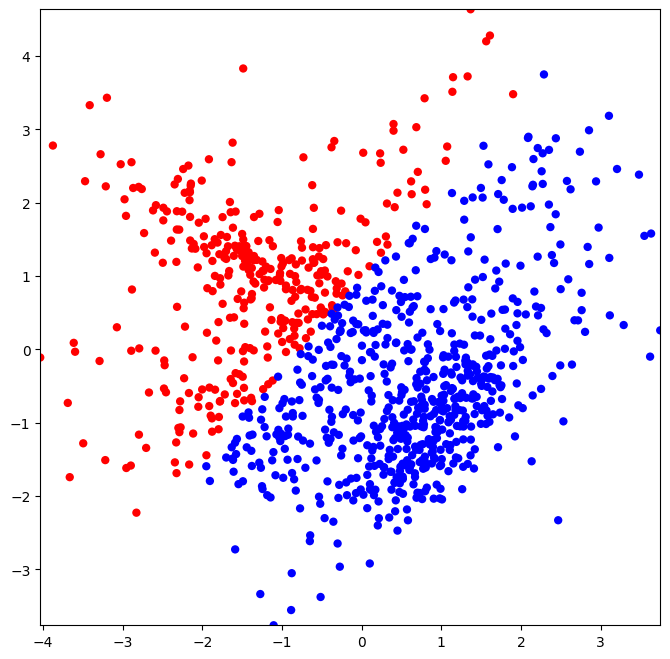

In [8]:
prediction = prob(w,b)>0

plot_classes(X, prediction)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This gives a pretty decent separation of the two classes, aside from the overlapping region.  What about a problem where the classes are clearly not linearly separable?
 </div>

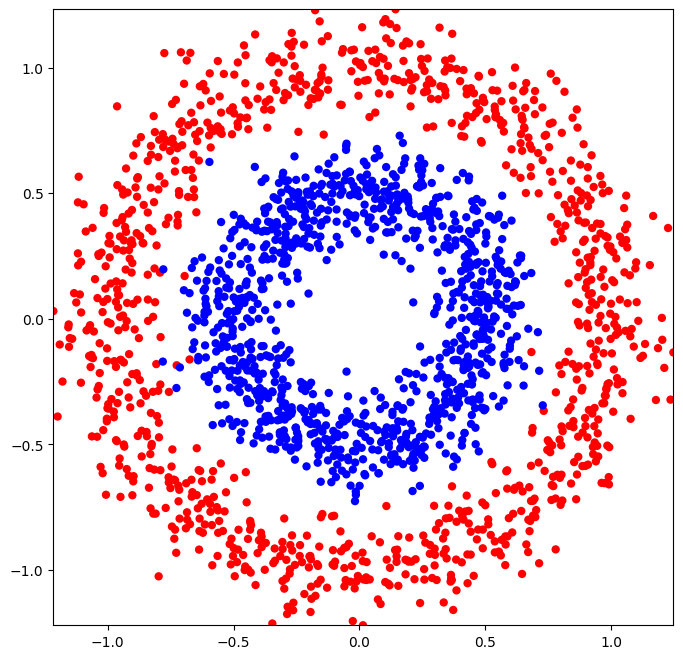

In [9]:
X, y = datasets.make_circles(noise=0.1, factor=0.5, random_state=1,n_samples=2000)

plot_classes(X,y)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


Let's do the computation again with the same gradients and code.
</div>

In [10]:
def prob(w,b):
    return 1.0/(1.0 - np.exp(-np.dot(X,w) - b))

def grad_w(w,b):
    return -np.mean(X.T*(y - prob(w,b)), axis=1)

def grad_b(w,b):
    return -np.mean((y - prob(w,b)))

In [11]:
w = np.random.random(2)
b = np.random.random()

learning_rate = 0.1

for t in range(100):
    w_last = w
    b_last = b
    
    w = w_last - learning_rate*grad_w(w_last, b_last)
    b = b_last - learning_rate*grad_b(w_last, b_last)
    
print(w,b)

[3.4513944  2.31564454] -1.9828780349336101


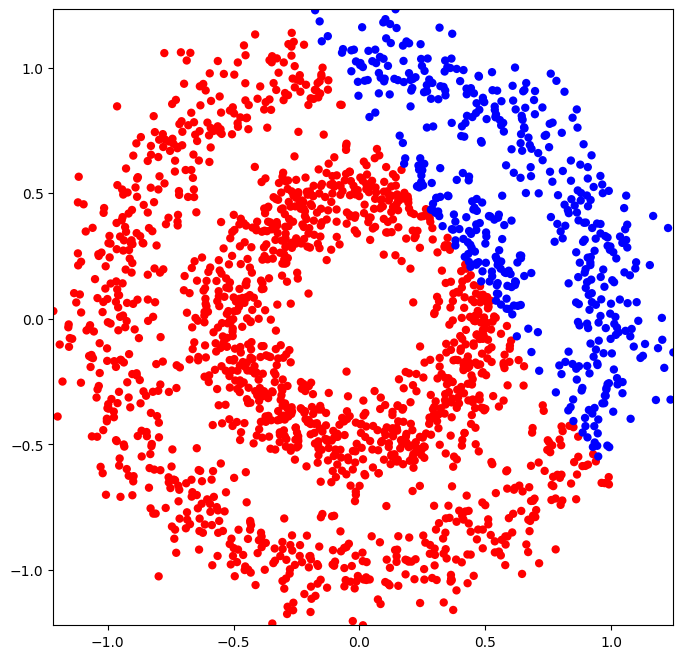

In [12]:
prediction = prob(w,b)>0

plot_classes(X, prediction)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">



Since this problem is not linearly separable, we have no chance of correctly fitting the data.  We can create a more complex model, but we will need to compute the gradients of the cost function with respect to more parameters.  This can quickly become unwieldy.  

Let's consider adding a single hidden layer to our model.  Now we have many parameters, and we have to consider the chain rule when deriving these gradients.
    
</div>

In [13]:
# m.shape = (2,num_hidden)
# b.shape = (num_hidden,)
# w.shape = (num_hidden,)

def hidden(m, b):
    temp = X.dot(m) + b
    temp[temp<0] = 0
    return temp    # shape is [samples, number_hidden]

def output(w, m, b):
    return hidden(m,b).dot(w)   # shape is [samples]

def prob(w,m,b):
    return 1.0/(1.0 + np.exp(-output(w,m,b)))

def grad_w(w,m,b):
    error = y - prob(w,m,b)
    return -hidden(m,b).T.dot(error)/len(y)

def grad_m(w,m,b):
    hidden_temp = X.dot(m) + b
    relu_prime = np.ones_like(hidden_temp)
    relu_prime[hidden_temp<0] = 0
    error = y - prob(w,m,b) 
    A = relu_prime.T*error
    return -X.T.dot(A.T)*w/len(y)

def grad_b(w,m,b):
    hidden_temp = X.dot(m) + b
    relu_prime = np.ones_like(hidden_temp)
    relu_prime[hidden_temp<0] = 0
    error = y - prob(w,m,b) 
    A = relu_prime.T*error
    return -np.mean(A.T*w, axis=0)    

In [14]:
num_hidden = 100
w0 = np.random.random(num_hidden)
m0 = np.random.random((2,num_hidden))
b0 = np.random.random(num_hidden)

In [15]:
w = w0
b = b0
m = m0

learning_rate = 0.1

for t in range(1000):
    w_last = w
    b_last = b
    m_last = m
    
    w = w_last - learning_rate*grad_w(w_last, m_last, b_last)
    b = b_last - learning_rate*grad_b(w_last, m_last, b_last)
    m = m_last - learning_rate*grad_m(w_last, m_last, b_last)
    
# print(w,b)

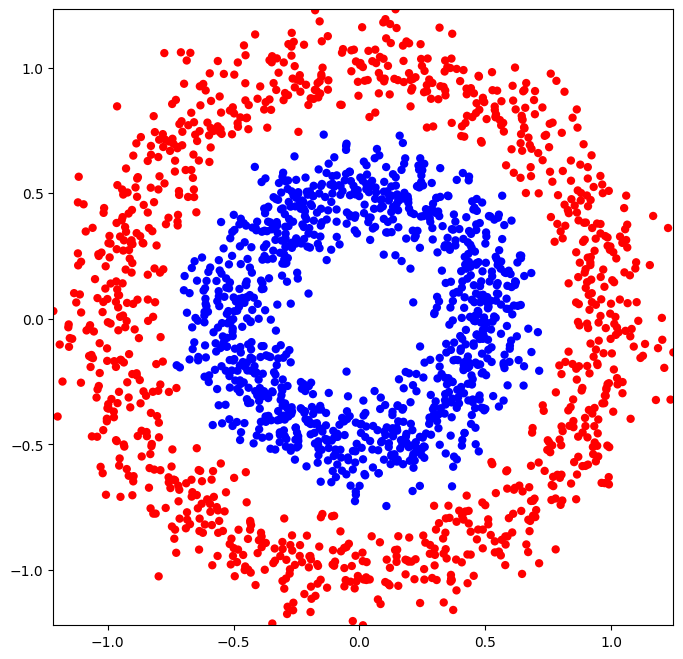

In [16]:
prediction = prob(w,m,b)>0.5

plot_classes(X, prediction)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


That worked!  But that was a LOT of work for a very simple model.  What if we wanted more than one hidden layer?  What if we wanted more complex types of computations such as convolutions?  In that case we would need to compute a complex set of derivatives and implement them individually for EACH model we wanted to consider.  

Similar to how `numpy` solves fast computation with `array`s and `pandas` provides access to relational data algorithms via the `DataFrame` object, PyTorch solves the problem of computing gradients by providing the `Tensor` object.
 </div>

In [17]:
torch.Tensor

torch.Tensor

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


In many respects, `Tensor`s look and behave similarly to `numpy` `array`s, with many of the same methods and behaviors.  (Warning: in some cases there is a change in method or argument name for what is essentially the same behavior in `numpy`.)
    
</div>

In [18]:
x = torch.Tensor([3,5,6,7])
print("x = ", x)

y = torch.Tensor([8,6,3,2])
print("y = ", y)

print("x + y = ", x+y)

x =  tensor([3., 5., 6., 7.])
y =  tensor([8., 6., 3., 2.])
x + y =  tensor([11., 11.,  9.,  9.])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


You can access values with bracket notation and you can use slicing in the same way.
    
</div>

In [19]:
print("x[3] = ", x[3])
print("x[1:3] = ", x[1:3])

x[3] =  tensor(7.)
x[1:3] =  tensor([5., 6.])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


There are similar construction methods as `array`s.
    
</div>

In [20]:
print("torch.arange(10): ", torch.arange(10))
print()
print("torch.ones(2,3):  \n", torch.ones(2,3))
print()
print("torch.zeros(2,5,6):  \n", torch.zeros(2,5,6))

torch.arange(10):  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

torch.ones(2,3):  
 tensor([[1., 1., 1.],
        [1., 1., 1.]])

torch.zeros(2,5,6):  
 tensor([[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


`Tensors` have shapes similar to `array`s, with the same conventions for axes.
    
</div>

In [21]:
z = torch.ones(2,5,6)
print(z.shape)

torch.Size([2, 5, 6])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">



There are also similar operations.   (Note that the optional argument below is called `dim` and not `axes`.)
</div>

In [22]:
print(torch.sum(z, dim=1))

tensor([[5., 5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5., 5.]])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


We can create `Tensor`s by initializing with `array`s.
    
</div>

In [23]:
x_numpy = np.random.random((3,3))

x = torch.Tensor(x_numpy)
print(x)

tensor([[0.7760, 0.0895, 0.6901],
        [0.5322, 0.7980, 0.4629],
        [0.6338, 0.0131, 0.9791]])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


We can also use the `from_numpy` method to convert from an `array` to a `Tensor`.  `Tensor`s created this way share the same data as the `array`.
</div>

In [24]:
x = torch.from_numpy(x_numpy)

print("Tensor:  \n", x)
x[:] = 0
print("Tensor:  \n", x)
print("Array:  \n", x_numpy)

Tensor:  
 tensor([[0.7760, 0.0895, 0.6901],
        [0.5322, 0.7980, 0.4629],
        [0.6338, 0.0131, 0.9791]], dtype=torch.float64)
Tensor:  
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
Array:  
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


Like `array`s, `Tensor`s have data types.  By default they are of type `torch.float64`.  If you wish to use GPUs, you may wish to convert these to `torch.float32`.  You can convert them with the `to` method or initialize them with the desired data type.  Note that `to` does not act in place.
</div>

In [25]:
print(x.dtype)

x = x.to(torch.float32)

print(x.dtype)

x = torch.ones((3,3), dtype=torch.float32)
print(x.dtype)

torch.float64
torch.float32
torch.float32


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


Creating an `array` from a `Tensor` can be done with the `.numpy` method.  The resulting `array` will share the same memory space as the `Tensor`.
</div>

In [26]:
xn = x.numpy()
print(x)
print(type(x))

x[:] = 0
print(xn)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
<class 'torch.Tensor'>
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are also convenience functions defined in PyTorch similar to those defined in `numpy`.  Many are particularly useful for machine learning applications.
</div>

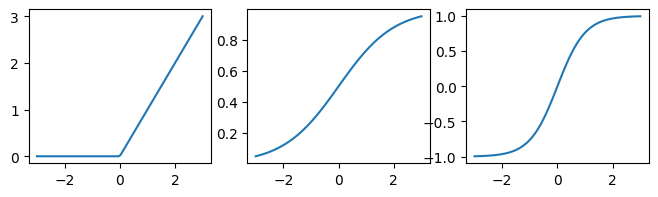

In [27]:


xs = torch.linspace(-3, 3, 100)
ys0 = torch.relu(xs)
ys1 = torch.sigmoid(xs)
ys2 = torch.tanh(xs)

fig, ax = plt.subplots(1,3, figsize=(8,2))
ax[0].plot(xs, ys0)
ax[1].plot(xs, ys1)
ax[2].plot(xs, ys2)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">



<h2> Automatic Differentiation </h2>

You might be wondering why we defined a whole new object that behaves exactly like one we already had.  

`Tensor`s are designed for *automatic differentiation*.  If we want to define a cost function for a multi-layer network, or any composition of complex functions, we will have a *computation graph* that defines the relationships among the different functions.  The chain rule of calculus then provides a similar set of relationships in order to compute the gradients of the parameters in that graph with respect to some defined cost function.  As long as the appropriate derivative is defined for each operation, automatic differentiation is the process of combining these derivatives according to the chain rule and the computation graph to get the required gradients for each parameter.  Even better, this can happen without any direct user involvement.  The entire computation happens under the hood.

How do `Tensor`s allow this?  They have a `data` property that contains the numerical data and they have a `grad` property that contains the gradient.
</div>

In [28]:
x = torch.ones(3)

print(x.data)
print(x.grad)

tensor([1., 1., 1.])
None


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


`grad` is a parameter that the tensor uses to store the gradient of some cost function with respect to the variable the `Tensor` represents. 

Why do we get `None` above?  `Tensor`s have a property `requires_grad` that determines whether that `Tensor` should be considered a variable that we wish to compute the gradient with respect to, or should be considered a constant.  By default, `requires_grad` is False, but we can define it when we create the `Tensor`.
</div>

In [29]:
print(x.requires_grad)
x = torch.ones(3, requires_grad=True)
print(x.requires_grad)

print(x.grad)

False
True
None


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


But we still get `None`.  Why?  Because we haven't defined anything that can act as a cost function!  Until a gradient is computed, `.grad` will return `None`.
</div>

In [30]:
y = torch.ones(3, requires_grad=True)

cost = torch.sum(torch.sigmoid(x**2 + 0.5*y**2))
print(cost)

tensor(2.4527, grad_fn=<SumBackward0>)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


Notice the `grad_fn` in the result above.  `grad_fn` defines the function that PyTorch will use to compute the gradient.  Since there are multiple operations that define `cost` above, several gradient computations will be nested.  We can access the computations at the next stage of the computation graph with `.next_functions`.
</div>

In [31]:
print("cost.grad_fn:  ", cost.grad_fn)
next_f = cost.grad_fn.next_functions
print("next functions: ", next_f)

cost.grad_fn:   <SumBackward0 object at 0x7fd783588f40>
next functions:  ((<SigmoidBackward0 object at 0x7fd783484550>, 0),)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can traverse the computation graph by repeatedly calling `.next_functions`.
    
</div>

In [32]:
op_list = [(cost.grad_fn,0)]

while len(op_list)>0:
    op, level = op_list.pop()
    if op is not None:
        op_list += [(next_op, level+1) for next_op, _ in op.next_functions]
    print("   "*level, op)

             None


In [33]:
print(x.grad)
print(y.grad)

None
None


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


The gradient for a cost function can be computed by calling `.backward`.  This will populate the `grad` property of any `Tensor`s that have `requires_grad==True`.
</div>

In [34]:
cost.backward()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


After calling `backward`, the gradients will accumulate in the `grad` property.
</div>

In [35]:
print(x.grad)
print(y.grad)

tensor([0.2983, 0.2983, 0.2983])
tensor([0.1491, 0.1491, 0.1491])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


Calling `backward` twice on the same cost function will raise a `RuntimeError`.
</div>

In [36]:
cost.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


However, we can create a new computation graph be redefining the cost function. Calling backward on this will add the gradient values to those already accumulated in `grad`.
</div>

In [37]:
cost2 = torch.sum(x**2 - y)

In [38]:
cost2.backward()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


The accumulated gradients are the sums of the gradients for the two cost functions. 
</div>

In [39]:
print(x.grad)
print(y.grad)

tensor([2.2983, 2.2983, 2.2983])
tensor([-0.8509, -0.8509, -0.8509])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


`Tensor`s with `requires_grad==True` cannot be converted to `numpy` arrays, nor can they be modified in place.  

The `.detach` method returns a `Tensor` with `requires_grad==False`.  

Warning: detached `Tensor`s share the same memory space and can be modified in place.
</div>

In [40]:
x.numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [41]:
x_np = x.detach().numpy()
print(type(x_np))

print("tensor:  ", x)
print("array:  ", x_np)

x_np[:]=0

print("tensor:  ", x)
print("array:  ", x_np)

<class 'numpy.ndarray'>
tensor:   tensor([1., 1., 1.], requires_grad=True)
array:   [1. 1. 1.]
tensor:   tensor([0., 0., 0.], requires_grad=True)
array:   [0. 0. 0.]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


The `clone` method will give a `Tensor` with a copy of the memory.
</div>

In [42]:
x_clone = x.detach().clone()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


Let's minimize the cost function from above.  Note that in each round through the `for` loop we are setting the gradients of each `Tensor` to zero.
</div>

In [43]:
x = torch.ones(3, requires_grad=True)
y = torch.ones(3, requires_grad=True)

print(x)
print(y)
print()

learning_rate = 0.1

for epoch in range(1000):
    
    cost = torch.sum(torch.sigmoid(x**2 + 0.5*y**2))
    cost.backward()
    
    x.data = x.data - learning_rate*x.grad
    y.data = y.data - learning_rate*y.grad
    
    x.grad.zero_()
    y.grad.zero_()
    
print(x)
print(y)

tensor([1., 1., 1.], requires_grad=True)
tensor([1., 1., 1.], requires_grad=True)

tensor([6.5510e-23, 6.5510e-23, 6.5510e-23], requires_grad=True)
tensor([1.1218e-11, 1.1218e-11, 1.1218e-11], requires_grad=True)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">



<h2> GPU support </h2>

One nice advantage of PyTorch is that it is very easy to use GPU computation.  The `to` method will move a `Tensor` to another device (a cpu or gpu).  In most cases, gpu support will be provided by the CUDA library from Nvidia.  You can check whether CUDA support is available for your environment by calling `torch.cuda.is_available`.

All `Tensor`s in a computation must be on the same device or it will raise an error.
</div>

In [44]:
torch.cuda.is_available()

False

In [45]:
num_gpus = torch.cuda.device_count()

print("number of gpus:  ", num_gpus)

for n in range(num_gpus):
    print(torch.cuda.get_device_name(n))

number of gpus:   0


In [46]:
device = torch.device("cuda:0")  # or "cuda"

print(device)
x_gpu = x.to(device)

cuda:0


AssertionError: Torch not compiled with CUDA enabled

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


If you have a recent Mac with Apple Silicon, there is also gpu support available, *if* you are using versions of Python and PyTorch compiled for ARM cpus.  The device name is `mps` (for Metal Performance Shaders).  Use `mps` in the same way you would use `cuda`.

(Note:  if you followed the setup instructions for installing Anaconda at the beginning of the course, you should have the x86 (i.e. Intel) version of Python installed.  If you want to play with gpu support on your M1/M2 laptop, ask an instructor about setting up an ARM environment.)
</div>

In [47]:
torch.device('mps')

device(type='mps')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">



<h2> The Network module </h2>

PyTorch provides a class that helps us build networks with multiple layers and complex interactions among operators.  This is in the `nn` ("neural network") submodule and is called `torch.nn.Module`.

`torch.nn.Module` is a class with specific useful properties.  Although we've talked about objects, we have not talked about defining classes in this course.  Briefly, for the `Module` type of object, you can define your own operations for a computation graph by specifying operators in a special method called `__init__` that runs when the object is created.  The operation of the network itself is given by the `forward` function, which defines how the operations are connected together in the graph.

The following example defines a network with two "hidden" layers with 32 units each connecting an input of `input_size` and an output of `output_size`.  `torch.nn.Linear` is an operator that defines a matrix multiplication with an additional bias term for each unit.  `torch.nn.ReLU` return an activation function that behaves like a rectified linear function.  
</div>

In [48]:
class Net(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 32)
        self.fc2 = torch.nn.Linear(32, 32)
        self.fc3 = torch.nn.Linear(32, output_size)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


You create the object with the following code:
</div>

In [49]:
network = Net(2,2)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


Let's use this network to solve the classficiation problem we solved above.
</div>

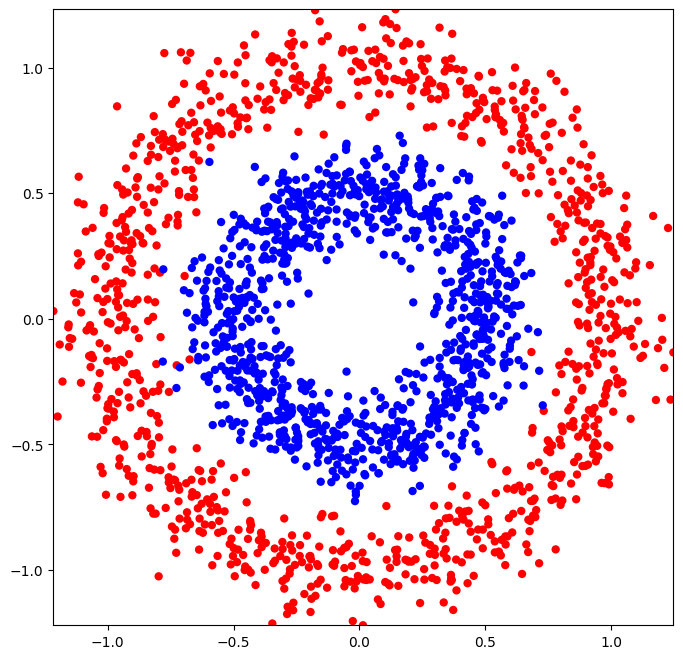

In [50]:
X, y = datasets.make_circles(noise=0.1, factor=0.5, random_state=1,n_samples=2000)

plot_classes(X,y)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


Let's separate these data into train and test, then define `Tensor`s so we can train our network.
</div>

In [51]:
X_train = X[:1000]
y_train = y[:1000]

X_test = X[1000:]
y_test = y[1000:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


PyTorch includes a selection of common cost functions that we can use to train networks.  Two useful cost functions are `torch.nn.MSELoss` and `torch.nn.CrossEntropyLoss`.  You can see other cost functions provided in https://pytorch.org/docs/stable/nn.html#loss-functions

Note that these methods return *functions*.  They are called by supplying input, target pairs. 
</div>

In [52]:
loss_function = torch.nn.CrossEntropyLoss()

loss =  loss_function(network(X_train_tensor),y_train_tensor)
print(loss)

tensor(0.6917, grad_fn=<NllLossBackward0>)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


In addition, the `optim` submodule provides a set of different optimizers (many different ways of updating weights for each round of training).  We can use these optimizers intead of manually updating the parameters of each network.



`torch.optim.SGD` is stochastic gradient descent, which is the standard simple update rule that we used above.  `lr` is the learning rate.  `.parameters` will return all of the `Tensor`s with that are trainable (i.e. have `requires_grad==True`) in a `Network`.  Calling `.step` will apply this update once gradients have been computed.

Typically before calling `step` with an optimizer, we should set the gradients of all tensors to zero so we don't accumulate computations from previous steps.  We can do this by calling `.zero_grad` for the optimizer, which will the gradient of all parameters to zero.

You can find other optimizers at https://pytorch.org/docs/stable/optim.html
</div>

In [53]:
optimizer = torch.optim.SGD(network.parameters(), lr=0.01)

optimizer.zero_grad()
loss.backward()
optimizer.step()

In [54]:
network = Net(2,2)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


Let's start by looking at the initial state of this network.
</div>

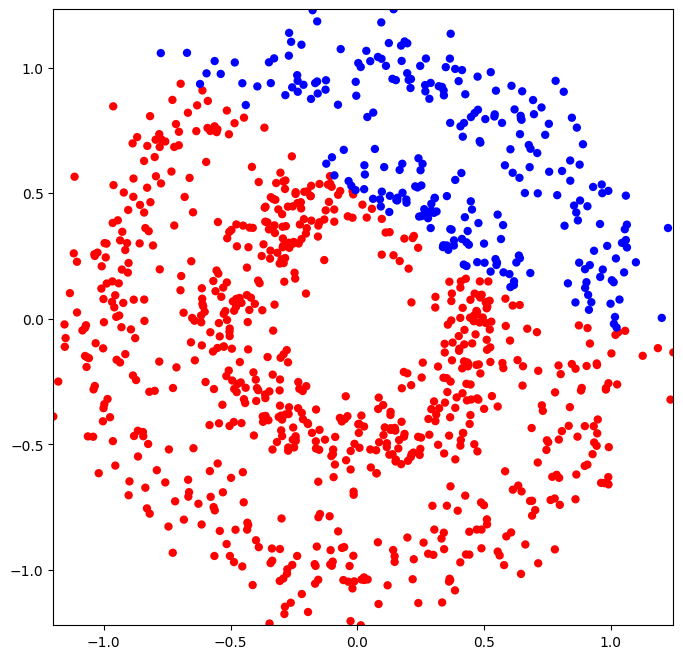

In [55]:
prediction = np.argmax(network(X_test_tensor).detach().numpy(), axis=1)

plot_classes(X_test_tensor, prediction)

In [58]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01)

num_epochs = 1000

for n in range(num_epochs):
    
    output = network(X_train_tensor)
    loss = loss_function(output,y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

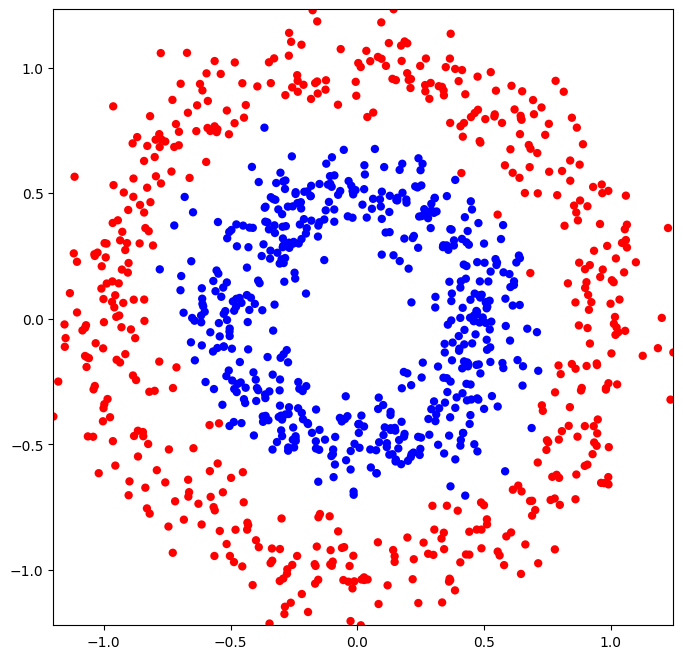

In [59]:
prediction = np.argmax(network(X_test_tensor).detach().numpy(), axis=1)

plot_classes(X_test_tensor, prediction)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">



During training, you may want to periodically check how your model is doing on a test or validation set.  Sometimes there are network properties that will behave differently in training vs. evaluation situations, such as Dropout and Batch Normalization (which we aren't using here).  In this case, you can specify which mode you want the network to operate in by calling `.train` and `.test`.  In addition, using the context `torch.no_grad` will disable gradient computation, which you will usually want to do when you are evaluating.  (The python keyword `with` is new for us.  It is used to establish contexts.)
</div>

In [60]:
network = Net(2,2)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01)

num_epochs = 2000

performance = []

for n in range(num_epochs):
    
    network.train()
    
    output = network(X_train_tensor)
    loss = loss_function(output,y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    network.eval()
    
    with torch.no_grad():
        output = network(X_test_tensor)
        prediction = np.argmax(network(X_test_tensor).detach().numpy(), axis=1)

        performance.append(np.mean(prediction==y_test_tensor.numpy()))

Text(0.5, 0, 'epoch')

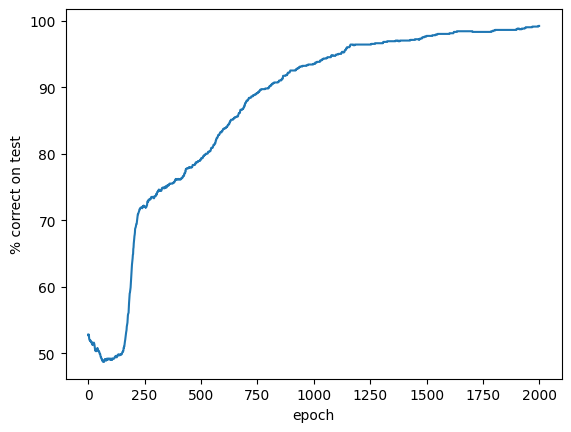

In [61]:
fig, ax = plt.subplots()

ax.plot(100*np.array(performance))
ax.set_ylabel('% correct on test')
ax.set_xlabel('epoch')